In [55]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [56]:
FNAME = "/home/carlos/projects/singlecell_Dec2024/cellranger1/A/outs/filtered_feature_bc_matrix.h5"
RAW_FNAME = "/home/carlos/projects/singlecell_Dec2024/cellranger1/A/outs/raw_feature_bc_matrix.h5"
#FNAME = "/home/carlos/projects/singlecell_Dec2024/cellranger1/run_count1_MERGED_mapped/outs/count/filtered_feature_bc_matrix.h5"
adata = sc.read_10x_h5(
    filename=FNAME
)
#backup_url="https://figshare.com/ndownloader/files/39546196",
adata

/home/carlos/miniforge3/envs/singlecell1/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/carlos/miniforge3/envs/singlecell1/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11498 × 33696
    var: 'gene_ids', 'feature_types', 'genome'

In [57]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 11498 × 33696
    var: 'gene_ids', 'feature_types', 'genome'

In [58]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [59]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 11498 × 33696
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

As we can see, the function added a couple of additional columns to .var and .obs. We want to highlight a few of them here, more information on the different metrics can be found in the scanpy documentation:

    - n_genes_by_counts in .obs is the number of genes with positive counts in a cell,

    - total_counts is the total number of counts for a cell, this might also be known as library size, and

    - pct_counts_mt is the proportion of total counts for a cell which are mitochondrial.

We now plot the three QC covariates n_genes_by_counts, total_counts and pct_counts_mt per sample to assess how well the respective cells were captured.

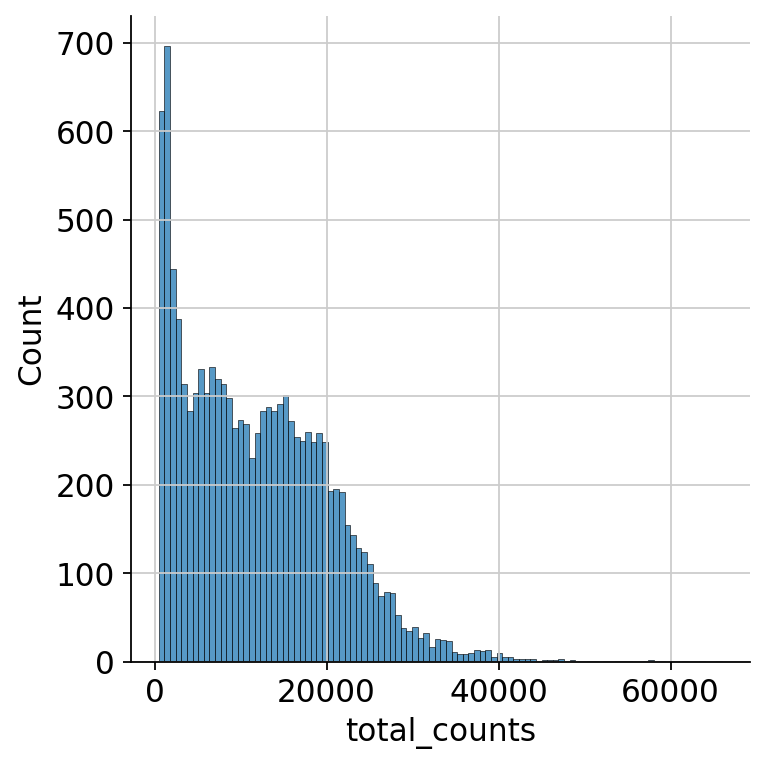

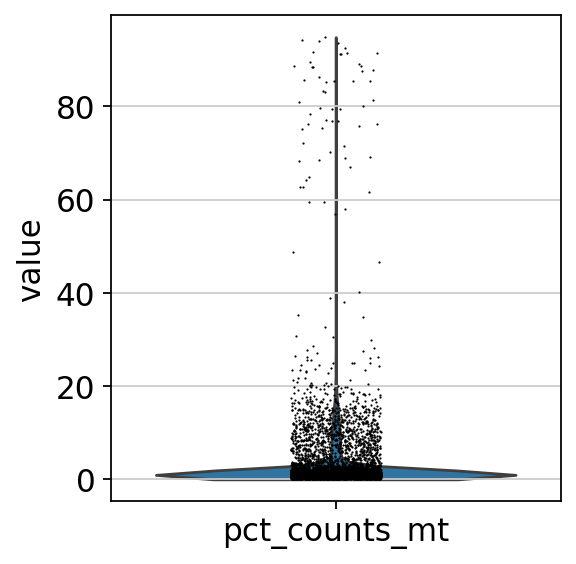

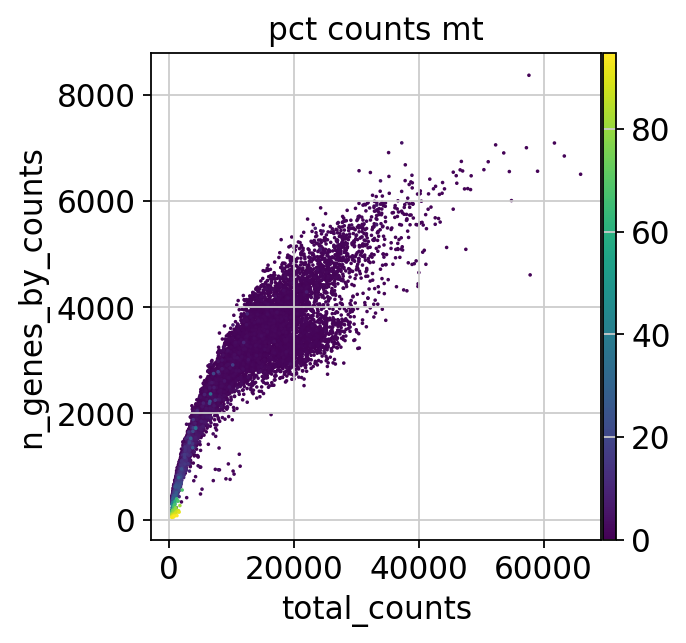

In [60]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [61]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()


adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()



mt_outlier
False    9654
True     1844
Name: count, dtype: int64

In [62]:
type(adata.obs)
adata.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,outlier,mt_outlier
AAACCAAAGCAAGCGA-1,3418,8.137103,24473.0,10.105367,59.951784,159.0,5.075174,0.649696,0.0,0.0,0.0,0.0,0.0,0.0,True,False
AAACCAAAGGAGCCTT-1,2010,7.606387,4110.0,8.321422,12.384428,43.0,3.784190,1.046229,0.0,0.0,0.0,0.0,0.0,0.0,False,False
AAACCAAAGGATTAGA-1,3908,8.271037,17315.0,9.759386,14.496102,468.0,6.150603,2.702859,0.0,0.0,0.0,0.0,0.0,0.0,False,True
AAACCAAAGGTAGTAA-1,790,6.673298,1606.0,7.382124,39.041096,494.0,6.204558,30.759651,0.0,0.0,0.0,0.0,0.0,0.0,True,True
AAACCAAAGGTGCTAC-1,2446,7.802618,7194.0,8.881142,12.774534,53.0,3.988984,0.736725,0.0,0.0,0.0,0.0,0.0,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTGTTGAGATAGGGT-1,1955,7.578657,5442.0,8.602086,14.369717,104.0,4.653960,1.911062,0.0,0.0,0.0,0.0,0.0,0.0,False,True
TGTGTTGAGCGCCACA-1,1414,7.254885,2821.0,7.945201,14.462956,16.0,2.833213,0.567175,0.0,0.0,0.0,0.0,0.0,0.0,False,False
TGTGTTGAGGTAATTC-1,735,6.601230,1400.0,7.244942,32.285714,116.0,4.762174,8.285714,0.0,0.0,0.0,0.0,0.0,0.0,True,True
TGTGTTGAGGTCACGT-1,3584,8.184514,15008.0,9.616405,14.805437,193.0,5.267858,1.285981,0.0,0.0,0.0,0.0,0.0,0.0,False,False


In [63]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 11498
Number of cells after filtering of low quality cells: 7675


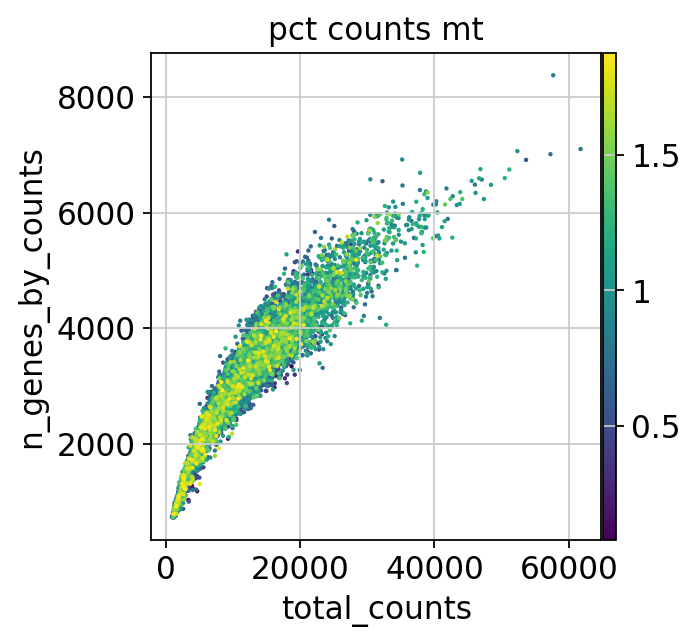

In [64]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# Backgraund removal with SoupX

In [65]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import os

os.environ['R_HOME'] = '/usr/bin/R'

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

print(ro.r('version'))

%load_ext rpy2.ipython


o{'platform': ['x86_64-conda-linux-gnu'], 'arch': ['x86_64'], 'os': ['linux-gnu'], 'system': ['x86_64, linux-gnu'], 'status': [''], 'major': ['4'], 'minor': ['3.3'], 'year': ['2024'], 'month': ['02'], 'day': ['29'], 'svn rev': ['86002'], 'language': ['R'], 'version.string': ['R version 4.3.3 (2024-02-29)'], 'nickname': ['Angel Food Cake'], }
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/tmp/ipykernel_17749/1737449570.py:12: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [66]:
%%R
library(SoupX)
sessioninfo::session_info()


Error in library(SoupX) : there is no package called ‘SoupX’


RInterpreterError: Failed to parse and evaluate line 'library(SoupX)\nsessioninfo::session_info()\n'.
R error message: 'Error in library(SoupX) : there is no package called ‘SoupX’'

In [67]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

In [68]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

del adata_pp

In [69]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

In [70]:
adata_raw = sc.read_10x_h5(
    filename=RAW_FNAME
)
#backup_url="https://figshare.com/ndownloader/files/39546217",
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T

/home/carlos/miniforge3/envs/singlecell1/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/carlos/miniforge3/envs/singlecell1/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [71]:
del adata_raw

In [ ]:
print(type(data.shape))
print(type(genes.shape))
print(type(cells.shape))
print(soupx_groups.shape)
#print(soupx_groups)
print(type(data_tod))

import pandas as pd
soupx_groups2 = pd.DataFrame({k:v for k, v in zip(["cells", "groups"], [i for i in zip(*soupx_groups)])} )
print(soupx_groups2)

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
(7675,)
<class 'scipy.sparse._csc.csc_matrix'>
AAACCAAAGGAGCCTT-1     0
AAACCAAAGGTGCTAC-1     2
AAACCATTCAATGGCC-1     4
AAACCCGCAAGTATGC-1     1
AAACCCGCACAACCCT-1     1
                      ..
TGTGTTAGTCAGGAAC-1     8
TGTGTTAGTTGGGACG-1    16
TGTGTTAGTTTGACAC-1     2
TGTGTTGAGCGCCACA-1     3
TGTGTTGAGGTCACGT-1     0
Name: soupx_groups, Length: 7675, dtype: category
Categories (28, object): ['0', '1', '2', '3', ..., '24', '25', '26', '27']


In [80]:
print(type(soupx_groups))
df = soupx_groups.to_frame()
print(df)

<class 'pandas.core.series.Series'>
                   soupx_groups
AAACCAAAGGAGCCTT-1            0
AAACCAAAGGTGCTAC-1            2
AAACCATTCAATGGCC-1            4
AAACCCGCAAGTATGC-1            1
AAACCCGCACAACCCT-1            1
...                         ...
TGTGTTAGTCAGGAAC-1            8
TGTGTTAGTTGGGACG-1           16
TGTGTTAGTTTGACAC-1            2
TGTGTTGAGCGCCACA-1            3
TGTGTTGAGGTCACGT-1            0

[7675 rows x 1 columns]


In [36]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

PackageNotInstalledError: The R package "Matrix" is not installed.

In [ ]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

In [ ]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

# Doublet detection